# **PROYECTO 3**

 # Sistema de Recomendaciones Steam

## **Parte A - Análisis Exploratorio**

In [1]:
#Librerías 
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc #garbage collector
from pandas_profiling import ProfileReport

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

## Reviews

#Se inicia abriendo el archivo json y pasandolo a csv.
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
contador = 0
data_reviews = []
n = 1
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
reviews = pd.DataFrame(data_reviews)

#se guarda el dataset 
reviews.to_csv('reviews.csv', index= False)

In [2]:
#se carga el dataset modificado y se imrimen las primeras instancias
reviews = pd.read_csv(r'reviews.csv')
#evitamos que los product_id aparezcan con notación cientrífica
pd.options.display.float_format = '{:.1f}'.format
#borramos duplicados
reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last')
#imprimimos las primeras instancias
reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,nan,NaN,nan
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,nan,NaN,nan
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,nan
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,nan,NaN,nan
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,nan,NaN,76561198007483072.0


In [3]:
#principales estadísticas de las variables numéricas
reviews.describe()

,hours,products,product_id,page_order,page,found_funny,user_id
count,7766532.0,7778108.0,7793069.0,7793069.0,7793069.0,1200756.0,3176223.0
mean,111.8,236.5,251380.5,4.5,893.0,7.9,76561198096417120.0
std,392.9,485.8,150112.0,2.9,1927.7,73.4,100841037.5
min,0.0,1.0,10.0,0.0,1.0,1.0,76561197960265808.0
25%,4.0,45.0,203770.0,2.0,52.0,1.0,76561198025640032.0
50%,15.3,110.0,252490.0,4.0,237.0,1.0,76561198071083136.0
75%,59.7,246.0,346110.0,7.0,829.0,3.0,76561198140793520.0
max,42100.7,18188.0,777950.0,9.0,18371.0,13318.0,76561198803033792.0


In [4]:
#iniciamos el análisis exploratorio con un profile
#reviews_profile = ProfileReport(reviews,title="Pandas Profiling Report")
#reviews_profile

**Features (con una breve descripción de los datos según Profile Report)**
- *username*: nombre del usuario, el 17.6% de los valores son únicos.
- *hours*: cantidad de horas jugadas al realizar el comentario.  Median=15.3 < Mean=111.8364833. La distribución tiene cola hacia la derecha.
- *products*: cantidad de productos adquiridos al realizar el comentario. median	110 < Mean	236.4839008.  La distribución tiene cola hacia la derecha.
- *product_id*: identificación del producto. hay 15474 juegos con comentarios.
- *page_order*: posición del comentario dentro de la página (cada juego tiene páginas de comentarios).  sus valores oscilan entre 1 y 10 y tiene una distribución uniforme. Esta columna no nos arroja información.-    
- *date*: fecha del comentario.  durante el mes de noviembre de los años 2016 y 2017 parecieran estar los picos.
- *text*: comentario. el valor más común es 'good game' y, al igual que todos los valores más frecuentes, indican valoraciones positivas.
- *early_access*: true si corresponde a un juego con acceso temprano.  el 13.8% de los reviews se realizaron sobre juegos con acceso temprano.
- *page*: página de comentario del juego. Median=237, Mean=893.0330963 (cada página tiene diez comentarios). Nuevamente se observa una cola hacia la derecha.
- *user_id*: id del usuario.  Hay 1426419 usuarios que realizaron comentarios
- *found_funny*: cantidad de usuarios para los que la review resultó divertida. el valor máximo es 13218. No sabemos para qué usuarios resultó divertido por lo que no podremos extrapolar el review.
- *compensation*: pago por juego. Product received for free =1,8%, el resto son missing. Esta columna no nos arroja información.

### **Missing Values**

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


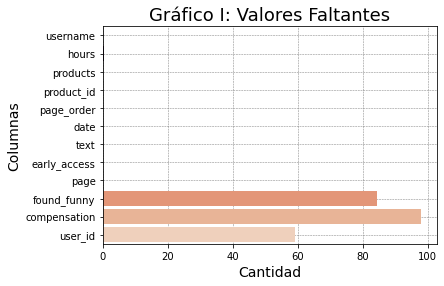

,Total,Percent
compensation,7647446,98.1
found_funny,6592313,84.6
user_id,4616846,59.2
hours,26537,0.3
text,17972,0.2
products,14961,0.2
username,208,nan


In [5]:
#Valores faltantes
missing=reviews.isna().sum()/len(reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=reviews.columns
##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico I: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()
def missing_percentage(df):
    total = reviews.isnull().sum().sort_values(ascending = False)[reviews.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(reviews.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(reviews.isnull().sum().sort_values(ascending = False)/len(reviews)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(reviews)

**Se descartarán found_funny y compensarion,Los dos primeros reatures serán descartados. El principal problema del dataset es que cuenta con casi el 60% de valores faltantes los id de los usuarios. No se encontró una solución al problema por lo que se eliminarán esos valores tras analizar el resto de las variables. También se eliminarpa page_order por no aportar información significativa.**

### **Descarte de columnas poco significativas+optimización de tipo de datos**

In [6]:
#se reorganiza el dataset tomando solo las columnas relevantes
reviews=reviews[['user_id','username','product_id','text','hours','products','date','page','early_access']]
#se eliminan los valores faltantes
#no se eliminan para user_id porque son demasiados
reviews.dropna(subset=['username'], how='all', inplace=True)
reviews.dropna(subset=['text'], how='all', inplace=True)
reviews.dropna(subset=['hours'], how='all', inplace=True)
reviews.dropna(subset=['products'], how='all', inplace=True)
#impresión de tipo de datos
reviews.dtypes

user_id         float64
username         object
product_id        int64
text             object
hours           float64
products        float64
date             object
page              int64
early_access       bool
dtype: object

In [7]:
#se optimizan los datatypes
reviews['product_id'] = reviews['product_id'].astype(np.uint32)
reviews['hours'] = reviews['hours'].astype(np.float16)
reviews['products'] = reviews['products'].astype(np.uint16)
reviews['page'] = reviews['page'].astype(np.uint16)
#reviews['user_id'] = reviews['user_id'].astype(np.int64)
#se guarda el dataset
#reviews.to_csv('reviews_opt.csv', index= False)

### **Preguntas sobre Reviews**

### 1- Dado que existen un 60% de missing_values para  user_id, podemos reemplazar esta columna con el nombre de los usuarios?

In [8]:
print(reviews.user_id.nunique())
print(reviews.username.nunique())

1416024
2551936


In [9]:
user_id_counts=reviews['user_id'].value_counts()
user_id_counts

76561198011965360.0    1252
76561198094803808.0     885
76561197969749888.0     750
76561198094321632.0     669
76561198073092176.0     548
                       ... 
76561198152970848.0       1
76561198084125136.0       1
76561198151266720.0       1
76561198017114496.0       1
76561198422425472.0       1
Name: user_id, Length: 1416024, dtype: int64

In [10]:
user_name_counts=reviews['username'].value_counts()
user_name_counts

123                  2036
Alex                 1737
Nick                 1457
Chris                1442
Tom                  1360
                     ... 
shoobnooter             1
Alan_Rifter             1
-|NFLD|-Fearlifta       1
csf0904                 1
THE MASKED MURDER       1
Name: username, Length: 2551936, dtype: int64

In [11]:
user=reviews[(reviews.username=='123')]
user.head()

,user_id,username,product_id,text,hours,products,date,page,early_access
29045,76561198021444240.0,123,1610,One of the best space games ive ever played,97.9,103,2014-02-02,9,False
29510,76561198072738320.0,123,271590,"Don't buy. They don't bother fixing bugs, only...",484.0,69,2017-12-30,107,False
47279,76561198141516112.0,123,427730,the game is boring without freinds but with th...,7.9,19,2016-12-29,205,False
49267,76561198120382960.0,123,35140,"Great game, with a good story. Lots to explore...",4.6,243,2016-06-30,242,False
51651,76561198194763872.0,123,350280,I enjoy games again.,68.5,145,2017-08-14,239,False


**Hay muchos user id que se loguean con diferentes usernames, por lo que no podremos recurrir al nombre para utilizarlos.**

### 2- ¿Cuáles son los juegos más comentados?

In [12]:
more_coments=reviews['product_id'].value_counts()
more_coments

440       181962
252490    102029
49520      72523
377160     70638
271590     58947
           ...  
502730         1
669490         1
706350         1
571990         1
736230         1
Name: product_id, Length: 15384, dtype: int64

In [13]:
more_comment=reviews[(reviews.product_id==440)]
more_comment.head()

,user_id,username,product_id,text,hours,products,date,page,early_access
3556479,76561198802074304.0,Sammy,440,P gud game,8.6,2,2018-01-05,1,False
3556484,76561198123688624.0,Blue Orangatang,440,Hands down the best multiplayer fps. I mean 10...,120.1,48,2018-01-05,1,False
3556490,nan,soup man,440,1,2856.0,65,2018-01-05,1,False
3556496,76561198411438896.0,It's ya girl,440,Its a very gud game recommend this game :D,327.2,3,2018-01-05,1,False
3556503,nan,Saggins,440,a decade old and its still funny,868.0,52,2018-01-05,1,False


**Los juegos más comentados son el 440, el 52490 y el 49520, cuando analicemoso el siguiente dataset sabremos de qué juegos se trata.**

## 3- ¿Cuántas horas  juega cada usuario?

In [14]:
reviews.hours.describe()

count   7733533.0
mean          nan
std           nan
min           0.0
25%           4.0
50%          15.4
75%          59.7
max       42112.0
Name: hours, dtype: float64

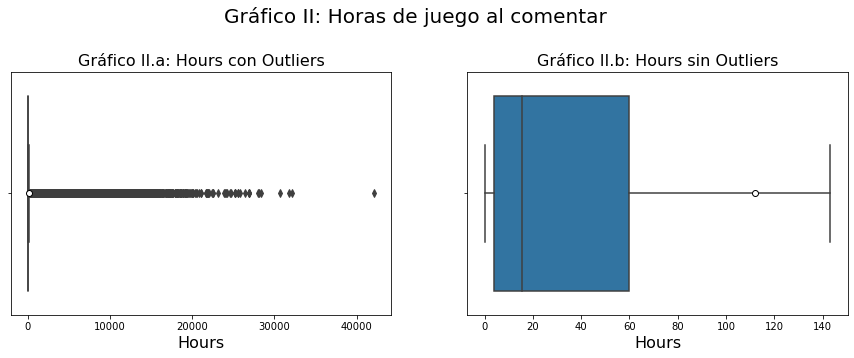

In [15]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico II: Horas de juego al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = reviews,x='hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = reviews,x='hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico II.a: Hours con Outliers",fontsize=16)
ax2.set_title("Gráfico II.b: Hours sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

**La mediana indica que los usuarios jugaron 15.4 horas a la hora de realizar los comentarios. Este valor puede resultar más representativo que el promedio dado que la distribución tiene una marcada cola hacia la derecha.**

### 4- Cuántos juegos tiene cada usuario?

In [16]:
reviews.products.describe()

count   7733533.0
mean        235.4
std         483.7
min           1.0
25%          45.0
50%         110.0
75%         245.0
max       18188.0
Name: products, dtype: float64

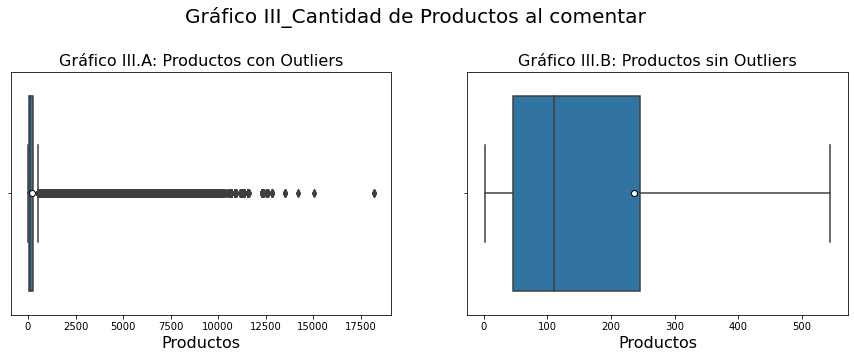

In [17]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico III_Cantidad de Productos al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = reviews,x='products',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
sns.boxplot(data = reviews,x='products',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico III.A: Productos con Outliers",fontsize=16)
ax2.set_title("Gráfico III.B: Productos sin Outliers",fontsize=16)
ax1.set_xlabel('Productos',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Productos',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

**En promedio, cada usuario tiene 235 juegos. La mediana es 110.**

### 6- Cuándo se realizaron los juegos?.

2018-01-05
2010-10-15


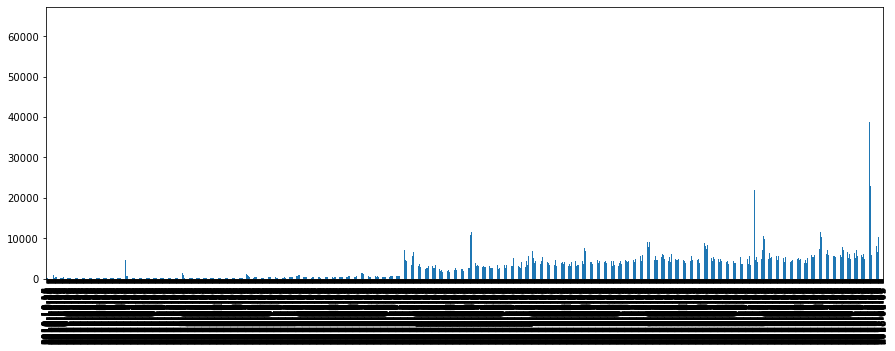

In [18]:
print(reviews.date.max())
print(reviews.date.min())
reviews['date'].value_counts().sort_index().plot(kind='bar', figsize=(15,5)) # ver layout

**Los primeros comentarios son del 2010-10-15 y los últimos del 2018-01-05. El gráfico muestra que existe una tendencia al aumento en la cantidad de comentarios a media que pasa el tiempo.**

# Data_Games

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
contador = 0
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
games = pd.DataFrame(data_games)

games.to_csv('games.csv', index= False)

In [19]:
#se carga el dataset modificado y se imrimen las primeras instancias
games = pd.read_csv(r'games.csv')
games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.5,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,nan
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",nan,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",nan,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.8,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,nan
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.8,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,nan


#iniciamos el análisis exploratorio con un profile
games_profile = ProfileReport(games,title="Pandas Profiling Report")
games_profile

In [20]:
games.describe()

,discount_price,id,metascore
count,225.0,32133.0,2607.0
mean,11.9,451757.4,72.3
std,17.5,182714.0,10.8
min,0.5,10.0,20.0
25%,1.4,329280.0,66.0
50%,4.2,452060.0,74.0
75%,22.7,593400.0,80.0
max,140.0,2028850.0,96.0


**Features (con una breve descripción según Pandas Profile)**
- publisher: empresa que publicó el juego. Existen 8230 valores únicos.
- genres: género del juego. El más frecuente es acción.
- app_name: nombre del juego. Hay 32094.
- title: nombre del juego alt. Hay 30054. App_name es más informativa.
- url:página del juego (Steam).
- release_date: fecha de lanzamiento. La más frecuente es 2012-10-16. Ese día se lanzó la plataforma.
- tags: categorías. Es similar a genres.
- discount_price: descuento. Missing 99.3%
- reviews_url: página de los comentarios (Steam).
- specs:especificaciones.
- price: precio
- early_access':acceso tempano Solo lo tienen un 6%.
- id: id del juego. 32132
- developer: empresa que publicó.Hay 10992 valores únicosl
- sentiment: el valor más frecuente es míxto. Sin embargo, en general las valoraciones son positivas.
- metascore: valoración de Metatric*
*sitio web que recopila reseñas de álbumes de música, videojuegos, películas, programas de televisión, DVD y libros.

## **Missing Values**

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


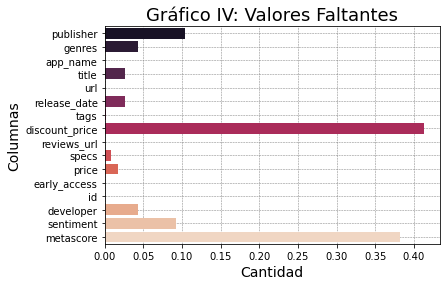

,Total,Percent
discount_price,31910,99.3
metascore,29528,91.9
publisher,8062,25.1
sentiment,7182,22.4
developer,3299,10.3
genres,3283,10.2
release_date,2067,6.4
title,2050,6.4
price,1377,4.3
specs,670,2.1


In [21]:
#Valores faltantes
missing=games.isna().sum()/len(reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=games.columns

##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico IV: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = games.isnull().sum().sort_values(ascending = False)[games.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(games.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(games.isnull().sum().sort_values(ascending = False)/len(games)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(games)

##  Selección de columnas relevantes+optimización de datatypes

In [22]:
games=games[['id','app_name','title','developer','publisher','sentiment','release_date','genres','specs','tags','price']]
games.head()

,id,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
0,761140.0,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",['Single-player'],"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.99
1,643980.0,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Strategy', 'Indie', 'RPG', '...",Free To Play
2,670290.0,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Simulation', 'Sports', 'Casu...",Free to Play
3,767400.0,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],"['Action', 'Adventure', 'Casual']",0.99
4,773570.0,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"['Single-player', 'Full controller support', '...","['Action', 'Indie', 'Casual', 'Sports']",2.99


### 1-¿Cuántos juegos hay?

In [23]:
games.rename(columns={'id':'product_id'},inplace=True)
games.dropna(subset=['product_id'], how='all', inplace=True)
games['product_id'] = games['product_id'].astype(np.int32)

games.set_index('product_id',inplace=True)
games.head()

,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
product_id,,,,,,,,,,
761140,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",['Single-player'],"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.99
643980,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Strategy', 'Indie', 'RPG', '...",Free To Play
670290,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Simulation', 'Sports', 'Casu...",Free to Play
767400,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],"['Action', 'Adventure', 'Casual']",0.99
773570,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"['Single-player', 'Full controller support', '...","['Action', 'Indie', 'Casual', 'Sports']",2.99


In [24]:
games.shape

(32133, 10)

Hay 32133 juegos, mientras que en reviews hay 15474 con comentarios.

### 2- Es mejor trabajar con app_name y title?

In [25]:
app_name=games['app_name'].value_counts()
app_name

Soundtrack                                        3
Wolfenstein II: The New Colossus                  2
Aliens: Colonial Marines - Reconnaissance Pack    2
Luna                                              2
AirMech® Soundtrack                               2
                                                 ..
Ninja Guy                                         1
THE GAME OF LIFE - The Official 2016 Edition      1
Shovel Knight: Treasure Trove                     1
Caves of Qud                                      1
NakedMan VS The Clothes                           1
Name: app_name, Length: 32094, dtype: int64

In [26]:
title=games['app_name'].value_counts()
title

Soundtrack                                        3
Wolfenstein II: The New Colossus                  2
Aliens: Colonial Marines - Reconnaissance Pack    2
Luna                                              2
AirMech® Soundtrack                               2
                                                 ..
Ninja Guy                                         1
THE GAME OF LIFE - The Official 2016 Edition      1
Shovel Knight: Treasure Trove                     1
Caves of Qud                                      1
NakedMan VS The Clothes                           1
Name: app_name, Length: 32094, dtype: int64

In [27]:
#como se vio anteriormente, existen valores faltantes que serán completados
games['app_name'] = games['app_name'].fillna(games['title'])
games['title'] = games['title'].fillna(games['app_name'])

**App name y title tienen la misma información, es mejor trabajar con app_name porque posee menos valores faltantes**

### 3 - Es mejor trabajar con developer o publisher?

In [28]:
games['developer'] = games['developer'].fillna(games['publisher'])
games['publisher'] = games['publisher'].fillna(games['developer'])

In [29]:
developers=games['developer'].value_counts()
developers

Ubisoft - San Francisco          1259
SmiteWorks USA, LLC               813
Dovetail Games                    253
KOEI TECMO GAMES CO., LTD.        232
Paradox Development Studio        156
                                 ... 
Eendhoorn Games                     1
Pooandplay                          1
Polyquest Games,ZXDigital Ltd       1
AMA,Mando Productions               1
Xtase Studios                       1
Name: developer, Length: 11011, dtype: int64

In [30]:
publishers=games['publisher'].value_counts()
publishers

Ubisoft - San Francisco       1081
SmiteWorks USA, LLC            813
Ubisoft                        404
Dovetail Games - Trains        360
Degica                         289
                              ... 
Semaphore                        1
Loju                             1
Eduard Kozadaev                  1
Quantum Entanglement Games       1
Xtase Studios                    1
Name: publisher, Length: 8783, dtype: int64

Publisher y developer poseen la misma información, es preferible trabajar con developer porque tiene menos valores faltntes.

### 4- Cuándo se publicaron los juegos?

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 21021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 38957 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 30330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda

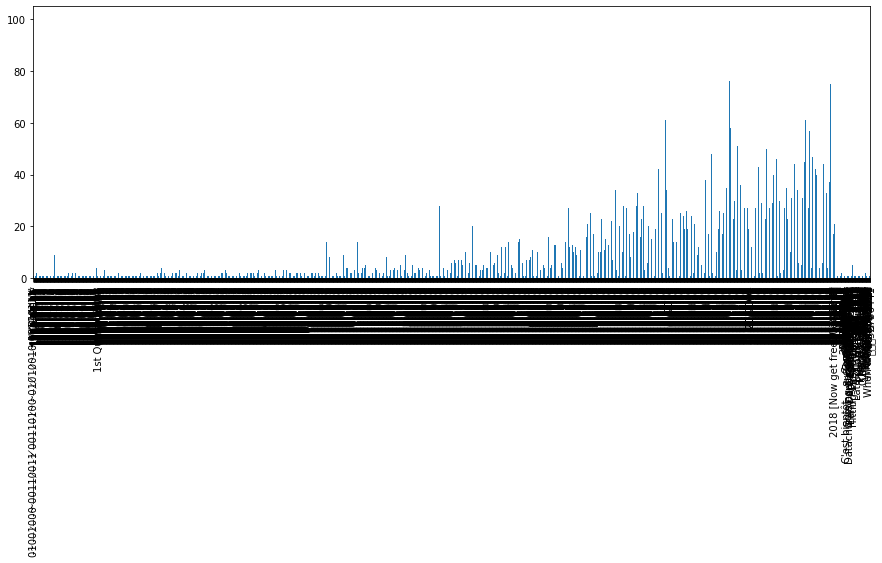

In [31]:
games['release_date'].value_counts().sort_index().plot(kind='bar', figsize=(15,5)) # ver layout

**Existe una tendencia a creciente a la publicación de juegos.**

### 5 - Breve exploración del contenido de cada juego.

In [32]:
genres=games['genres'].value_counts()
genres

['Action']                                                                            1880
['Action', 'Indie']                                                                   1650
['Simulation']                                                                        1396
['Casual', 'Simulation']                                                              1359
['Action', 'Adventure', 'Indie']                                                      1082
                                                                                      ... 
['Adventure', 'Casual', 'Indie', 'Racing', 'Simulation', 'Sports', 'Early Access']       1
['Action', 'Adventure', 'Indie', 'Casual']                                               1
['Action', 'Sports', 'Strategy', 'Early Access']                                         1
['Action', 'Adventure', 'Casual', 'Simulation']                                          1
['Action', 'Adventure', 'Free to Play', 'Indie', 'RPG', 'Simulation', 'Strategy']        1

In [33]:
specs=games['specs'].value_counts()
specs

['Single-player']                                                                                                                                                                   2794
['Single-player', 'Downloadable Content']                                                                                                                                           1204
['Single-player', 'Shared/Split Screen', 'Downloadable Content', 'Steam Achievements', 'Steam Trading Cards', 'Partial Controller Support', 'Steam Cloud', 'Steam Leaderboards']    1015
['Single-player', 'Steam Achievements']                                                                                                                                              824
['Multi-player', 'Co-op', 'Cross-Platform Multiplayer', 'Downloadable Content']                                                                                                      756
                                                                           

In [34]:
tags=games['tags'].value_counts()
tags

['Casual', 'Simulation']                                                                                                                        1292
['Action']                                                                                                                                      1105
['Simulation']                                                                                                                                  1085
['Strategy', 'RPG', 'Indie']                                                                                                                     632
['Strategy']                                                                                                                                     625
                                                                                                                                                ... 
['Strategy', 'Indie', 'Rogue-like', 'RTS', 'Pixel Graphics']                                              

**Dado que el sistema de recomendación no es de contenido, esta variable no se trabajará en detalle.**

### 6 - Cómo son los comentarios sobre los juegos? 

In [35]:
valoraciones=games['sentiment'].value_counts()
valoraciones

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     302
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64

In [36]:
#by_metascore = games.sort_values('metascore',ascending=True)
#by_metascore.head(40)

Estas dos varibiables indicarían en términos generales las valoraciones de los juegos. Metascore tiene muchos valores faltantes, por lo qe será prioritaria sentiment.

## **Combinación de Datasets**: 

**Pregunta Interesante: ¿Existe una relación entre la valoración al comentar y la cantidad de horas jugadas?**

In [37]:
comb1=reviews[['user_id','product_id','text','hours']]
comb1= comb1.reset_index(drop=True)

#se reaorganizan las columnas
comb2=games[['app_name','sentiment']]

comb=pd.merge(comb1,comb2, on='product_id')

                                    user_id  product_id  hours
sentiment                                                     
Very Positive           76561198098010560.0    237144.1  127.2
Mixed                   76561198094859168.0    299331.8  116.9
Overwhelmingly Positive 76561198096450832.0    207395.3   98.3
Mostly Positive         76561198094637072.0    292795.2   83.7
Mostly Negative         76561198078926400.0    296288.0   24.4
Positive                76561198090314928.0    431777.1   14.6
7 user reviews          76561198091009984.0    438876.6   12.3
4 user reviews          76561198110746672.0    469484.7    8.9
Overwhelmingly Negative 76561198053242192.0    264741.0    8.4
6 user reviews          76561198087343136.0    459915.2    7.8
9 user reviews          76561198098260736.0    472845.7    7.5
8 user reviews          76561198085868432.0    428452.9    7.0
Very Negative           76561198059618704.0    304417.5    6.9
2 user reviews          76561198098232368.0    501469.2

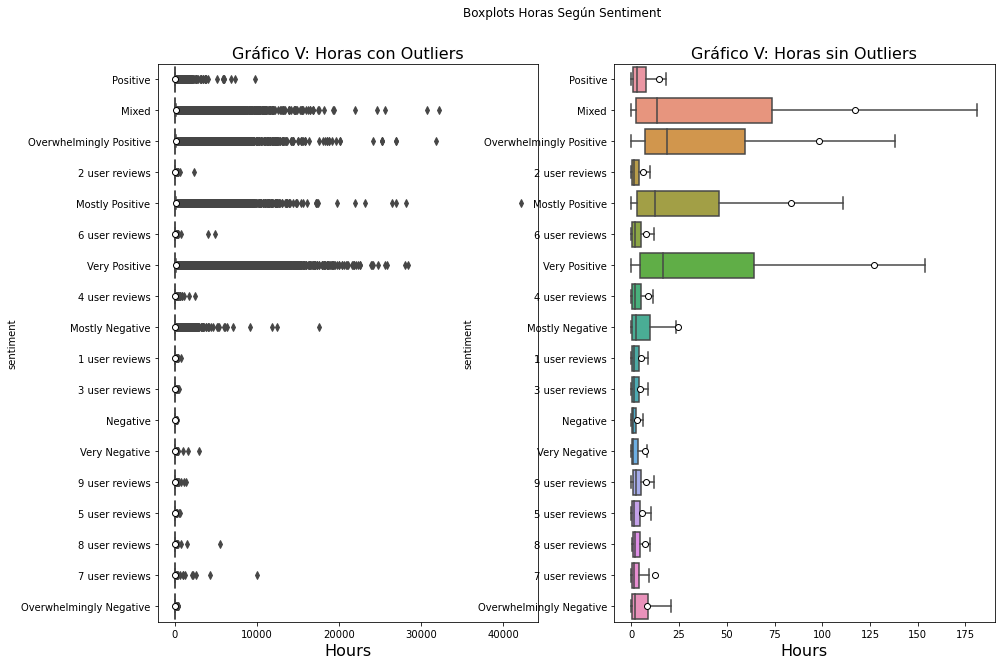

In [38]:
grouped=comb.groupby('sentiment').mean().sort_values(('hours'),ascending=False)
print(grouped)
#Boxplot Rooms
fig=plt.figure(figsize=(15,10))
plt.suptitle('Boxplots Horas Según Sentiment', ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = comb, x = "hours",y='sentiment',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = comb, x = "hours",y='sentiment',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico V: Horas con Outliers",fontsize=16)
ax2.set_title("Gráfico V: Horas sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

No existen diferencias significativas en cuanto a la cantidad de horas jugadas para juegos con valoraciones positivas y valoraciones negativas, por lo que la variable sentiment no será considerada.
El sistema de recomendación se generará considerando que a los usuarios les gustó un juego cuando

## **Feature Enginering**

In [39]:
#mapeo
grouped=reviews.groupby('user_id').median().sort_values(('hours'),ascending=False).head(20)
#reorganizacion de columnas
#prop=prop[['rooms','bathrooms','surface_covered','surface_discovered','surface_total','property_type','l3','price_m2','price']]
#mapeo
#grouped=reviews.groupby('user_id').mean().sort_values(('price_m2'),ascending=False).head(20)
grouped

,product_id,hours,products,page,early_access
user_id,,,,,
76561198030129760.0,8930.0,31808.0,6.0,977.0,0.0
76561198046297712.0,47410.0,30736.0,3.0,109.0,0.0
76561198037002256.0,212200.0,26480.0,46.0,209.0,0.0
76561198118821296.0,440.0,25600.0,19.0,13623.0,0.0
76561198032909472.0,8500.0,23184.0,90.0,343.0,0.0
76561198052967696.0,211820.0,22576.0,107.0,560.0,0.0
76561198052254896.0,220700.0,21824.0,68.0,57.0,0.0
76561198004382528.0,45100.0,21616.0,715.0,135.0,0.0
76561198127682368.0,39210.0,21056.0,39.0,606.0,0.0


**Crearemos una nueva columna con la media de la cantidad de horas al realizar los comentarios. Si el valor de la columna horas es igual o mayor que est nuevo feature, consideraremos que el juego le gustó al usuario.**

In [40]:
encod_type = reviews.groupby('user_id')['hours'].median()
reviews.loc[:, 'median_hours'] = reviews['user_id'].map(encod_type)

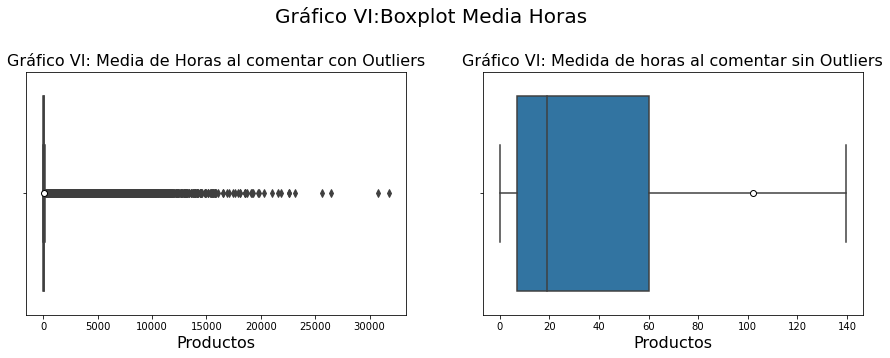

In [41]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico VI:Boxplot Media Horas',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = reviews,x='median_hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
sns.boxplot(data = reviews,x='median_hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico VI: Media de Horas al comentar con Outliers",fontsize=16)
ax2.set_title("Gráfico VI: Medida de horas al comentar sin Outliers",fontsize=16)
ax1.set_xlabel('Productos',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Productos',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

In [42]:
#comenzamos borrando los valores nan de user id
reviews.dropna(subset=['user_id'], how='all', inplace=True)
reviews['implicit_rating'] = np.where(reviews['hours']>=reviews['median_hours'], 1, 0)
reviews['implicit_rating'] = reviews['implicit_rating'].astype(np.uint8)
reviews=reviews[['user_id','implicit_rating','product_id']]
reviews
reviews = reviews.reset_index(drop=True)
reviews
#transformación de los tipos de datos
#reviews['hours'] = reviews['hours'].astype(np.float64)
reviews['user_id'] = reviews['user_id'].astype(np.int64)
reviews['product_id'] = reviews['product_id'].astype(np.uint32)
reviews.dtypes

user_id             int64
implicit_rating     uint8
product_id         uint32
dtype: object

In [43]:
reviews

,user_id,implicit_rating,product_id
0,76561198007483072,0,35140
1,76561197970402784,0,707610
2,76561198060686752,1,328100
3,76561198023491408,0,35140
4,76561198115331808,1,35140
...,...,...,...
3153701,76561197962161824,1,252490
3153702,76561198010660368,1,252490
3153703,76561197983773024,1,252490
3153704,76561198089897920,1,252490


In [44]:
games=games[['app_name']]
games

,app_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


# **B - Machine Learning**

14.5.1 Semejanza entre usuarios (User User)
Supongamos que queremos estimar las calificaciones que le faltan al usuario “i”.
Lo que hacemos es buscar los usuarios mas similares a “i” y luego estimar las
calificaciones faltantes en base a un promedio ponderado de las calificaciones
de los dem´as usuarios ponderadas de acuerdo a la semejanza que tengan con
nuestro usuario “i”.
Necesitamos entonces una funci´on de semejanza entre usuarios sim(u,v) que
calcule cu´an similares son dos usuarios en base a las calificaciones que han realizado los mismos. Cuanto m´as parecidas sean estas calificaciones m´as parecidos
ser´an los usuarios. Usuarios que han calificado conjuntos de ´ıtems disjuntos
tendr´an semejanza nula.
Una de las funciones m´as usadas para calcular la semejanza es la funci´on de
correlaci´on de Pearson:
sim(x, y) =
P
s∈Sxy
(rxs−rx)(rys−ry)
qP
s∈Sxy
(rxs−rx)
2
qP
s∈Sxy
(rys−ry)
2
(14.11)
Donde rx es el promedio de calificaciones del usuario x.
Notemos que si los promedios de calificaciones fueran cero entonces la funci´on
de correlaci´on de Pearson es el coseno entre x e y (dividido la productoria
de sus normas). En muchos casos se empieza entonces por centrar todas las
calificaciones de los usuarios en cero, es decir restarle a cada calificaci´on el
promedio del usuario.

### Benchmark - SVD

In [46]:
reader = Reader(rating_scale = (0,1))

In [47]:
#creamos el DatasetSurprise
#N_filas=100000
data=Dataset.load_from_df(reviews[['user_id','product_id','implicit_rating']], reader)

In [48]:
trainset, testset = train_test_split(data, test_size=.25)

## Entrenamiento

In [49]:
#definimos
La medida de similitud elegida es la que viene por defecto, es decir, similitud coseno.
from surprise import SVD
#sim_options = {'name': 'pearson','user_based': True  # compute  similarities between items
               }
algo = SVD()

In [50]:
#entrenamos
algo.fit(trainset)

In [51]:
#predecimos
predictions = algo.test(testset)

## Testeo

In [52]:
#vemos un ej. de predicción 
predictions[1]

Prediction(uid=76561198122276112, iid=440900, r_ui=0.0, est=0.7117213146620465, details={'was_impossible': False})

In [53]:
#estimamos para un usuario y un juego
#algo.predict(76561198011965359,440)
algo.predict(76561198011965360,440)

Prediction(uid=76561198011965360, iid=440, r_ui=None, est=0.8599624331871916, details={'was_impossible': False})

In [54]:
#películas que le gustaron a un usuario
usuario = 76561198023491408
rating = 1  

df_user = reviews[(reviews['user_id'] == usuario) & (reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = games['app_name'].loc[df_user.product_id].values
df_user

,user_id,implicit_rating,product_id,app_name
0,76561198023491408,1,337000,Deus Ex: Mankind Divided
1,76561198023491408,1,268050,The Evil Within
2,76561198023491408,1,238430,Contagion
3,76561198023491408,1,379720,DOOM
4,76561198023491408,1,9480,Saints Row 2
5,76561198023491408,1,222480,Resident Evil Revelations / Biohazard Revelations
6,76561198023491408,1,261640,Borderlands: The Pre-Sequel
7,76561198023491408,1,223470,POSTAL 2
8,76561198023491408,1,360430,Mafia III
9,76561198023491408,1,588430,Fallout Shelter


In [55]:
#películas que no le gustaron a un usuario
rating = 0  

df_user = reviews[(reviews['user_id'] == usuario) & (reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = games['app_name'].loc[df_user.product_id].values
df_user

,user_id,implicit_rating,product_id,app_name
0,76561198023491408,0,35140,Batman: Arkham Asylum Game of the Year Edition
1,76561198023491408,0,214250,I Am Alive
2,76561198023491408,0,20530,Red Faction
3,76561198023491408,0,238090,Sniper Elite 3
4,76561198023491408,0,20500,Red Faction Guerrilla Steam Edition
5,76561198023491408,0,20900,The Witcher: Enhanced Edition Director's Cut
6,76561198023491408,0,13210,Unreal Tournament 3 Black
7,76561198023491408,0,209160,Call of Duty®: Ghosts
8,76561198023491408,0,99300,Renegade Ops
9,76561198023491408,0,2610,GUN™


In [56]:
#cuáles vio?
usuario_vistas = reviews[reviews['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas

(110, 3)


,user_id,implicit_rating,product_id
3,76561198023491408,0,35140
6804,76561198023491408,1,337000
32290,76561198023491408,0,214250
88240,76561198023491408,0,20530
139341,76561198023491408,0,238090
...,...,...,...
2908948,76561198023491408,0,280
2918672,76561198023491408,0,12120
2942219,76561198023491408,0,209000
2973500,76561198023491408,1,234140


In [57]:
#acá guardamos las recomendaciones
recomendaciones_usuario=games.copy()

#borramos las vistas
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.shape
recomendaciones_usuario

,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
32019,773640,Colony On Mars
32020,733530,LOGistICAL: South Africa
32021,610660,Russian Roads
32022,658870,EXIT 2 - Directions


In [58]:
#recomendamos
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario

,product_id,app_name,Estimate_Score
20328,547900,Front Office Football Eight,0.8
1976,286460,Black Mirror II,0.8
21851,288220,Backstage Pass,0.8
24559,412270,Stories of Bethem: Full Moon,0.8
8594,446060,akeytsu Indie,0.8
...,...,...,...
27576,339470,Retention,0.0
17525,489370,Quarantine,0.0
6519,490820,Fly O'Clock,0.0
3381,359560,Shutter,0.0


## Evaluación

Utilizaremos el rmse. La principal crítica a esta métrica es que ciertos
errores no son tan importantes como otros ya que cometer errores
con los juegos que más le gustaron al usuario es mas grave que cometer errores
sobre los juegos que no le han gustado o con calificaciones intermedias.

In [60]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.4364


0.43644162427719285

## Optimizacón de parámetros

In [61]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,10,12]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4331  0.4332  0.4331  0.4332  0.0001  
Fit time          35.02   42.04   38.21   38.42   2.87    
Test time         9.14    9.42    8.75    9.10    0.27    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4331  0.4327  0.4333  0.4330  0.0003  
Fit time          37.14   32.13   31.74   33.67   2.46    
Test time         8.54    8.03    7.81    8.13    0.30    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4329  0.4332  0.4331  0.4331  0.0001  
Fit time          34.18   34.99   34.67   34.61   0.33    
Test time         8.36    7.91    9.79    8.69    0.80    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

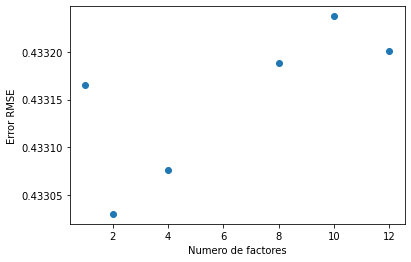

In [62]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

Parámetros a optimizar:

- n_factors : el número de factores.

- n_epochs : el número de iteraciones del descenso por gradiente estocástico.

- lr_all : la tasa de aprendizaje de todos los parámetros.

- reg_all : término de regularización para todos los parámetros. 

In [63]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [2],'n_epochs': [10,20,30], 'lr_all': [0.002, 0.005, 0.008],
              'reg_all': [0.01, 0.02,0.03]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs.fit(data)

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [64]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.42452233719868704
{'n_factors': 2, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.03}


## SVD++

In [67]:
#definimos
from surprise import SVDpp
algo = SVDpp()

In [68]:
algo.fit(trainset)

In [69]:
#predecimos
predictions = algo.test(testset)

In [70]:
#vemos un ej. de predicción 
predictions[1]

Prediction(uid=76561198122276112, iid=440900, r_ui=0.0, est=0.6583615993775502, details={'was_impossible': False})

In [71]:
from surprise import accuracy
accuracy.rmse(predictions)


RMSE: 0.4158


0.4157826648375647

In [72]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVDpp(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4212  0.4202  0.4182  0.4199  0.0012  
Fit time          219.22  214.66  207.32  213.73  4.90    
Test time         16.81   16.40   17.03   16.74   0.26    

Número de Factores: 2
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4187  0.4184  0.4182  0.4184  0.0002  
Fit time          206.94  222.85  226.88  218.89  8.61    
Test time         17.82   19.96   17.66   18.48   1.05    

Número de Factores: 4
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4182  0.4179  0.4183  0.4181  0.0002  
Fit time          232.66  245.23  241.90  239.93  5.32    
Test time         18.68   19.77   19.86   19.44   0.54    


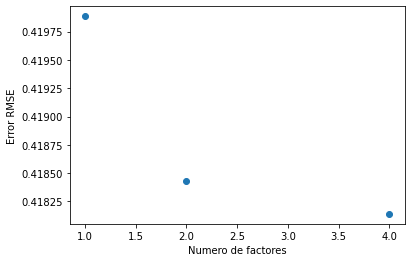

In [73]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [74]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [4],'n_epochs': [10,20,30], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.01, 0.02,0.03 ]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs.fit(data)

In [75]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.4122830997858415
{'n_factors': 4, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.01}


**A partir de correr los dos modelos y optimizar hiperparámetros, se elije como mejor modelo a SVD++ porque minimiza el RMSE en el valor 0.4122830997858415.
Los hiperparámetros seleccionados son:

- n_factors': 4, 

- n_epochs': 20

- lr_all': 0.005, 

- reg_all: 0.01

#  **C - Investigación**

1 - Una primera opción de mejora del modelo es utilizar procesamiento del lenguaje natural para poder interpretar el texto de cada review. Utilizando librerías vistas en clase como NLTK se podría alcanzar una mejor interpretación de la columna "text" del dataset "Reviews".
Con esto se podría verificar la hipotesis planteada tras realizar la "pregunta interesante": se graficaron boxplots que expresan la distribución de horas según el tipo de comentarios de cada juego y se verificó que no hay una relación directa entre el tiempo jugado al realizar el review y las valoraciones indicadas en el dataset "games". Según este análisis, por ejemplo, los juegos con comentarios Mixtos tienen una media y una mediana mayor de horas de juegos que los aquellos con reviews mayoritariamente positivos, lo cual no sería muy lógico a priori aunque podría suceder, por ejemplo, que usuarios comenten negativamente juegos que les gusta solo por el hecho de querer realizar "críticas objetivas" o por estar influenciados por otros comentarios.

2 - Otra oportunidad de mejora sería establecer una métrica superadora al rmse ya que en en las preferencias reales, algunos errores no son tan importantes como otros, por ejemplo si un usuario utilizó durante muchas horas un juego y el sistema predice que no le gusta tenemos un error igual a 1, que es el mismo error que existe entre un juego que no le gusta y que el sistema recomienda. Sin embargo el primero es bastante mas importante que el segundo ya que a la hora de recomendar
queremos encontrar los juegos que le gustan. En definitiva cometer errores
con los juegos que mas le gustaron al usuario es mas grave que cometer errores
sobre los juegos que no le han gustado o con calificaciones intermedias.  MPR (Mean Reciprocal Rank)
 y MAP (Mean Average Precision) son métricas basadas en el orden que intentan atacar este problema.

3 - Otra posibilidad de mejora sería estudiar modificaciones que permitan garantizar el cumplimiento de la serendipity: podrían eliminarse las recomendaciones obvias, por ejemplo, quitando de recomendaciones_usuario los juegos más populares. 

4 - Finalmente, también se podría desarrollar un algoritmo que nos permita recomendar
ítems nuevos. Algunos de estos ítems van a ser buenos y otros no, incluso pueden ser muy malos. Tenemos que
descubrir cuáles serán realmente buenos mediante experimentación. Los algoritmos que se
encargan de este tipo de cuestiones se denominan ”multi-armed bandits”
